In [ ]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms

In [33]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        loss = output[:, class_idx]
        loss.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)

        cam = F.relu(cam)
        cam = cam.squeeze().cpu().numpy()

        cam = cv2.resize(cam, (input_tensor.shape[3], input_tensor.shape[2]))
        cam = cam - cam.min()
        cam = cam / cam.max()

        return cam


In [35]:
sys.path.append(r"C:\epf\5a\ia\tumor-detection")
from src.datasets.mri_dataset import MRIDataset
dataset = MRIDataset(
    root_dir=r"C:\epf\5a\ia\tumor-detection\data\raw\Training"
)


# Charger l'image du dataset
img, label = dataset[0]


transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # IRM → 3 canaux
    transforms.ToTensor(),                         # (C, H, W) + [0,1]
])

img_tensor = transform(img).unsqueeze(0)

print(img_tensor.shape)



torch.Size([1, 3, 512, 512])


In [ ]:
# Définir et initialiser le modele avec ResNet18
model = models.resnet18(pretrained=True)

num_classes = 2
model.fc = nn.Linear(model.fc.in_features, num_classes)


# Genererer la carte Grad-CAM
model.eval()
target_layer = model.layer4[-1]

gradcam = GradCAM(model, target_layer)
cam = gradcam.generate(img_tensor)


c:\Users\Windows10\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Windows10\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Windows10\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. 

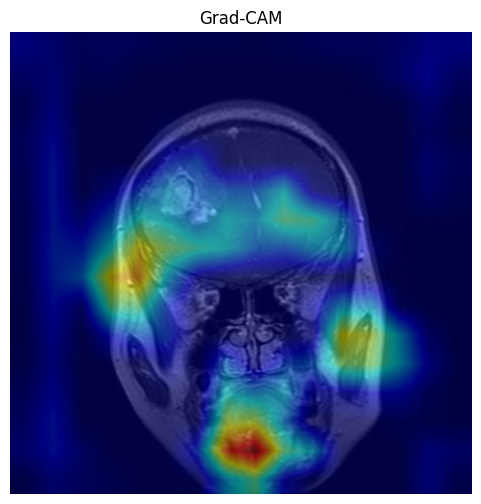

In [37]:
# Superposer la carte Grad-CAM sur l'image originale
def show_gradcam(image, cam):
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    image = image / image.max()
    overlay = 0.5 * heatmap / 255 + 0.5 * image

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("Grad-CAM")
    plt.show()
# Image originale
image_np = np.array(img).astype(np.float32) / 255.0  # (H, W, C)
if image_np.ndim == 2:
    image_np = np.stack([image_np]*3, axis=-1)  # faire 3 canaux


show_gradcam(image_np, cam)
